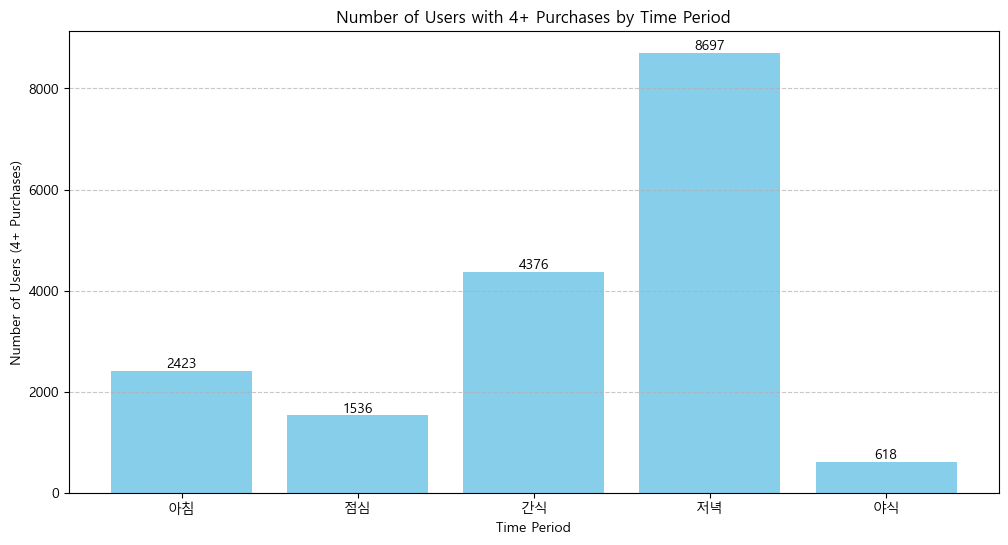

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

# CSV 파일 로드 (파일 경로는 실제 파일 경로로 수정)
data = pd.read_csv('combined_log_data.csv', parse_dates=['event_time'], low_memory=False)

# 'order' 이벤트만 필터링
# 추가적으로 service 가 mart_pickup 인 데이터 필터링
purchase_data = data[(data['inter'] == 'order') & (data['service'] == 'mart_pickup')].copy()

# 시간대 정보 추가
purchase_data['event_time'] = pd.to_datetime(data['event_time'], errors='coerce')
purchase_data['date'] = purchase_data['event_time'].dt.date
purchase_data['hour'] = purchase_data['event_time'].dt.hour

# 시간대별 구간 설정
def get_time_period(hour):
    if 5 <= hour < 12:
        return "아침"  # 5~11시 59분
    elif 10 <= hour < 14:
        return "점심"  # 10~13시 59분
    elif 14 <= hour < 17:
        return "간식"  # 14~16시 59분
    elif 17 <= hour < 21:
        return "저녁"  # 17~20시 59분
    elif (21 <= hour <= 23) or (0 <= hour < 1):
        return "야식"  # 21~00시 59분
    else:
        return None  # 해당되지 않는 시간대 (예: 1시~4시)

purchase_data['time_period'] = purchase_data['hour'].apply(get_time_period)

# 같은 날 같은 시간대에 구매한 경우 하나로 처리
user_period_purchase = purchase_data.groupby(['user_id', 'date', 'time_period']).size().reset_index(name='daily_purchase_count')

# 시간대별로 사용자별 구매 횟수를 다시 집계 (하루에 한 번으로 처리된 값)
user_period_purchase = user_period_purchase.groupby(['user_id', 'time_period']).size().reset_index(name='purchase_count')

# 이후 코드는 동일
frequent_purchase_users = user_period_purchase[user_period_purchase['purchase_count'] >= 4]
period_user_counts = frequent_purchase_users.groupby('time_period')['user_id'].nunique().reset_index()
period_user_counts.columns = ['time_period', 'user_count']

# 시간대 순서 지정
time_period_order = ["아침", "점심", "간식", "저녁", "야식"]
period_user_counts['time_period'] = pd.Categorical(period_user_counts['time_period'], categories=time_period_order, ordered=True)
period_user_counts = period_user_counts.sort_values('time_period')

# 기본 폰트를 한글이 포함된 폰트로 설정
plt.rcParams['font.family'] = 'Malgun Gothic'  # 'Malgun Gothic' 사용 예시
plt.rcParams['axes.unicode_minus'] = False  # 음수 기호가 제대로 보이도록 설정

# 그래프 그리기
plt.figure(figsize=(12, 6))
bars = plt.bar(period_user_counts['time_period'], period_user_counts['user_count'], color='skyblue')
plt.xlabel('Time Period')
plt.ylabel('Number of Users (4+ Purchases)')
plt.title('Number of Users with 4+ Purchases by Time Period')
plt.grid(axis='y', linestyle='--', alpha=0.7)

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, int(yval), ha='center', va='bottom')

plt.show()